# **System Kinematics Assignment**
EGR 557 - Group 6 

# **Team Members**
Cole Brauer @ cbrauer@asu.edu\
Fuchen Chen @ fchen65@asu.edu\
Nathaniel Rossi @ ntrossi@asu.edu\
Mason Smith @ mosmith3@asu.edu

# **Install Dependencies**

In [ ]:
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

     |████████████████████████████████| 92kB 4.7MB/s 
     |████████████████████████████████| 1.6MB 10.9MB/s 


## **Import Packages**

In [ ]:
%matplotlib inline

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.constraint import Constraint
from pynamics.output import PointsOutput

import sympy
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

from math import pi

## **Assignment**

### **1. Create a figure (either in python, in a vector-based drawing program like inkscape or illustrator, or as a solidworks rendering) of your system kinematics.**

The arangement of linkages was selected to follow the layout of the bones and tendons in the leg of a kangaroo rat. For the linkage representing ankle tendon, a passive spring-loaded joint was added to simulate tendon elasticity during landing impacts. Frames were assigned at one end of each link, and link dimensions were taken from the measurements of a kangaroo rat.

![diagram](https://drive.google.com/uc?export=download&id=1371ht69Wqoiih9L6xaQRC4UUc6G840On)

![dimension](https://drive.google.com/uc?id=1hJGP6pgFedYKX3fvvwl1TvXNcYxwv64R)

### **2. Make the device in paper or cardboard. You need an up-to-date model if it has changed from your individual assignments. The paper model should dimensionally match your code.**

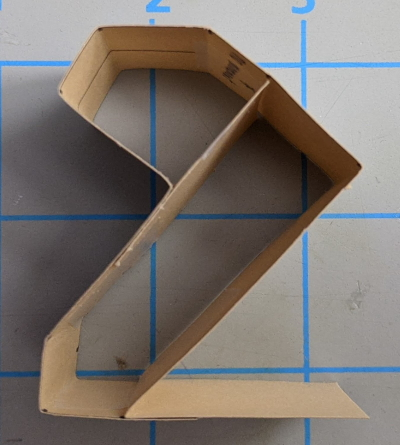

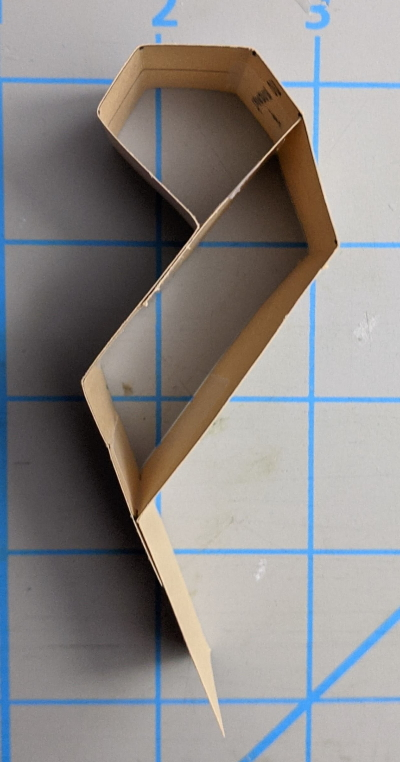

 ### **3. Using a pynamics-based script, develop a kinematic model for your device.**

Based on the figure in section 1, the required constants, variables, and frames were defined.

In [ ]:
# Variables, constants, and frames
system = System()
pynamics.set_system(__name__,system)

ln = Constant(15,'ln',system)
la1 = Constant(10,'la1',system)
la2 = Constant(17,'la2',system)
lb = Constant(10,'lb',system)
lc = Constant(20,'lc',system)
ld1 = Constant(20,'ld1',system)
ld2 = Constant(25,'ld2',system)
le = Constant(46,'le',system)
lf = Constant(10,'lf',system)
lg1 = Constant(10,'lg1',system)
lg2 = Constant(32,'lg2',system)

qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qG,qG_d,qG_dd = Differentiable('qG',system)

state_variables = system.get_state_variables()

N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')
E = Frame('E')
F = Frame('F')
G = Frame('G')

system.set_newtonian(N)

A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(N,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(A,[0,0,1],qD,system)
E.rotate_fixed_axis_directed(A,[0,0,1],qE,system)
F.rotate_fixed_axis_directed(D,[0,0,1],qF,system)
G.rotate_fixed_axis_directed(F,[0,0,1],qG,system)

The linkage kinematics were defined. Constraints were added to connect the joints at $p_{CD}$ and $p_{EG}$.


In [ ]:
# Kinematics
pNA=0*N.x
pNB=-ln*N.x
pNC = pNB + lb*B.x
pND = pNA + la1*A.x
pND1 = pNC + lc*C.x
pND1_p = pND + ld1*D.x
pNE = pNA + (la1+la2)*A.x
pNF= pND + (ld1+ld2)*D.x
pNG = pNF + lf*F.x
pNG1 = pNG + lg1*G.x
pNG1_p = pNE + le*E.x
pNH = pNG+(lg1+lg2)*G.x # Toe

# Constraint equations
eq = [
    (pND1-pND1_p).dot(N.x),
    (pND1-pND1_p).dot(N.y),
    (pNG1-pNG1_p).dot(N.x),
    (pNG1-pNG1_p).dot(N.y),
] 

A function for numerically solving for the joint positions was created to allow valid initial configurations to be found. A function for plotting the mechansim was also implemented.

In [ ]:
# Position given inputs

# Numerically solve for position of the points based on inputs
def solve_position(qi,qd,points):
    # Make qi constant beacuse it is the input in fk
    constants = system.constant_values.copy()
    constants.update(dict([(q,qi[q]) for q in qi]))

    variables = list(qi.keys())+list(qd.keys())
    guess = []
    for v in variables:
        if v in qi: 
            guess.append(qi[v])
        elif v in qd:  
            guess.append(qd[v])
        else:
            guess.append(0)

    eq_c = np.array([e.subs(constants) for e in eq]) # Constraint equations with constance subbed in
    error = eq_c.dot(eq_c)

    # Objetive function based on the error equation
    def obj(args):
      return sympy.lambdify(variables,error)(*args)

    result = scipy.optimize.minimize(obj,guess) # Numeric optmization

    sv_values = []
    for sv in system.get_state_variables():
        if sv in variables:
            sv_values.append(result.x[variables.index(sv)])
        else:
            sv_values.append(0) # Assume zero speed, will not affect point locations
    
    points_output = PointsOutput(points, constant_values=system.constant_values)
    points_output.calc(np.array([sv_values,sv_values]))
    
    return result.x, points_output.y[0,:,:]

def plot(ps, style='r', label='model'):
    ps_ADD1CB = np.array([
        ps[0,:],
        ps[3,:],
        ps[4,:],
        ps[2,:],
        ps[1,:],
        ps[0,:],
    ])
    ps_DEG1GF = np.array([
        ps[3,:],
        ps[5,:],
        ps[8,:],
        ps[7,:],
        ps[6,:],
        ps[3,:],
    ])    
    ps_G1H = np.array([
        ps[8,:],
        ps[9,:]
    ])    
    
    plt.plot(ps_ADD1CB[:,0],ps_ADD1CB[:,1],style)
    for p, l in zip(ps_ADD1CB[:-1,:],['A','D','D1','C','B']):
        plt.text(p[0],p[1],l)
        
    plt.plot(ps_DEG1GF[:,0],ps_DEG1GF[:,1],style)
    for p, l in zip(ps_DEG1GF[1:-1,:],['E','G1','G','F']):
        plt.text(p[0],p[1],l)
        
    plt.plot(ps_G1H[:,0],ps_G1H[:,1],style)
    for p, l in zip(ps_G1H[1:,:],['H']):
        plt.text(p[0],p[1],l)

    plt.plot([],[],style,label=label)    
    plt.axis('equal')    
    plt.legend()

The internal Jacobian was found and a substitution dictionary was created.

In [ ]:
# Velocity given input
# Analytical equations that relate velocity to input velocity

# Time derivative of constraint equation
eq_d = sympy.Matrix([(system.derivative(e)) for e in eq]) 
# Independent variables
qd_i = sympy.Matrix([qA_d, qB_d, qF_d])
# Dependent variables
qd_d = sympy.Matrix([qC_d, qD_d, qE_d, qG_d])

A_coeff = eq_d.jacobian(qd_i)
B_coeff = eq_d.jacobian(qd_d)
# THIS INVERSE TAKES A WHILE!!!
qd_d_exp = -B_coeff.inv(method='LU')*A_coeff*qd_i
qd_d_exp_list = [(v, exp) for v, exp in zip(qd_d, qd_d_exp)]

The Jacobian for the desired end-effector was then found.

In [ ]:
# Jacobian
# print(sympy.atan2(pNH.dot(N.y),pNH.dot(N.x)))
output = [pNH.dot(N.x), pNH.dot(N.y),sympy.atan2(G.x.dot(N.y),G.x.dot(N.x))]
output_d = sympy.Matrix([(system.derivative(e)) for e in output])

output_d = output_d.subs(qd_d_exp_list)
input_d = sympy.Matrix([qA_d, qB_d, qF_d])
J = output_d.jacobian(input_d)

### **4. Select or Solve for a valid initial condition that represents the system in the middle of a typical gait, when it is both moving and when forces are being applied to it (or to the world by it)**

Valid initial configurations were found numerically using the previously created function. Two solutions were found for slight variations in the input values to aid in verifying the Jacobian.

In [ ]:
# Solve for initial condition
qs1,ps1 = solve_position(
    {qA:-25*pi/180, qB:-135*pi/180, qF:90*pi/180}, # Input value
    {qC:90*pi/180, qD:-90*pi/180, qE:-90*pi/180 ,qG:30*pi/180}, # Guess values
    [pNA,pNB,pNC,pND,pND1,pNE,pNF,pNG,pNG1,pNH] # Points to calculate, use this order to ensure plot is correct
)
print(qs1)
print(ps1)
# Plot one close to initial condition(only qF moved a bit)
# For verifying Jacobian
qs2,ps2 = solve_position(
    {qA:-25*pi/180, qB:-135*pi/180, qF:91*pi/180}, # Input value
    {qC:90*pi/180, qD:-90*pi/180, qE:-90*pi/180 ,qG:30*pi/180}, # Guess values
    [pNA,pNB,pNC,pND,pND1,pNE,pNF,pNG,pNG1,pNH] # Points to calculate, use this order to ensure plot is correct
)

2021-02-22 08:46:07,004 - pynamics.output - INFO - calculating outputs
2021-02-22 08:46:07,006 - pynamics.output - INFO - done calculating outputs


[-0.43633231 -2.35619449  1.57079633  1.77374098 -1.94056282 -1.88232585
  0.54939865]
[[  0.           0.        ]
 [-15.           0.        ]
 [-22.07106781  -7.07106781]
 [  9.06307787  -4.22618262]
 [ -5.36875683 -18.07255898]
 [ 24.47031025 -11.41069307]
 [-23.40855313 -35.3805271 ]
 [-16.48536546 -42.5964451 ]
 [ -6.81303503 -45.13534724]
 [ 24.13842234 -53.25983407]]


2021-02-22 08:46:10,292 - pynamics.output - INFO - calculating outputs
2021-02-22 08:46:10,294 - pynamics.output - INFO - done calculating outputs


### **5. Plot the system in this position.**

The system was plotted for each of the intitial positions determined in the previous section.

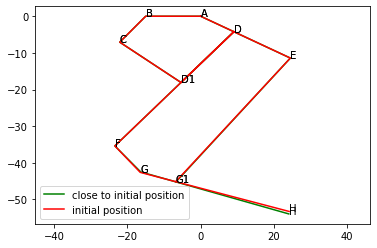

In [ ]:
# Plot
plt.figure()
plot(ps2,'g','close to initial position')
plot(ps1,'r','initial position')
# Estimate velocity
vH_est = (ps2[9,:]-ps1[9,:]).reshape((2,1))

The output velocity for each of these positions was calculated using the Jacobian. The resulting values were similar, which supports that the Jacobian was correctly calculated.

In [ ]:
# Output velocity at above poses
qs_list = [(q,val) for q,val in zip([qA,qB,qF,qC,qD,qE,qG],qs1)]
const_list = [(c, system.constant_values[c]) for c in system.constant_values]

vq=np.array(qs2[:3]-qs1[:3]).reshape(3,1) # Calculate input velocity based on the above poses 
J_init = np.array(J.subs(qs_list+const_list)).astype(float)
vH = J_init.dot(vq) # Output velocity

# These two results should be similar if Jacobian is correct
print(vH[:2,:])
print(vH_est) 

[[-0.08476246]
 [-0.6818762 ]]
[[-0.0925338 ]
 [-0.67439775]]


### **6. From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience. Consider including, based on your research**

The expected force vector for a landing impact was found based on the properties of a kangaroo rat's jumping. This vector is assumed to only act normal to the ground plane.

In [ ]:
# VALUES NEED TO BE UPDATED TO MATCH BIOMECHANICS
from math import sqrt
import numpy as np

g = 9.81    # gravity (meter/sec^2)

#m = 0.104
#h =  1      # Height that robot is dropped from (meter)

m = np.mean([0.078,0.102,0.120,0.091])    # mass of kangaroo rats [1]
h=0.5 # Peak jump height [2]
d = 0.2     # Deformation cosntant

# Some kinematic physics equations
impact_velocity = sqrt(2*g*h)
E_potential = m*g*h               # Potential energy before falling
F_mag = E_potential/d             # Newtons felt on toe
uv_dir = np.array([[0, 1, 0]])       # Applied normal to the ground on toe
F_ee = (F_mag*uv_dir).transpose() # Force on end effector at end of fall

# Display results

print(f'\nimpact_velocity = {impact_velocity}')
print(f'Mass = {m}')
print(f'Potential Energy = {E_potential}')
print(f'F_ee = \n {F_ee}')


impact_velocity = 3.132091952673165
Mass = 0.09775
Potential Energy = 0.47946375
F_ee = 
 [[0.        ]
 [2.39731875]
 [0.        ]]


### **7. Calculate the force or torque required at the input to satisfy the end-effector force requirements**

Based on the estimated impact force, the torque requirements for the input joints were found. For the two control joints, this represents the torque that motors would need to withstand during impact. For the passive spring joint, this represents the torque value at which the joint will stop rotating.

In [ ]:
# Evaluate torque on the inputs with Jacobian
T_input = np.matmul(J_init.transpose(),F_ee)
#T_input = np.matmul(J_instance.transpose(),F_ee)/1000 # jacobian was calculated in mm


# Display results
print(f'Jacobian Shape: {J_init.shape}')
print(f'F_ee Shape: {F_ee.shape}')
print(f'\n T_input =\n {T_input}')
print(f'F_ee = \n {F_ee}')
print(f'Jacobian: \n {J_init}')

Jacobian Shape: (3, 3)
F_ee Shape: (3, 1)

 T_input =
 [[189.8000527 ]
 [-71.60907214]
 [-93.65995552]]
F_ee = 
 [[0.        ]
 [2.39731875]
 [0.        ]]
Jacobian: 
 [[ 25.99453418  14.7987937   -4.85653144]
 [ 79.17180504 -29.87048433 -39.06862845]
 [  1.77275888  -0.41943056  -1.13214002]]


### **8. Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.**

*This may not be directly solvable based on your device kinematics; an iterative guess-and-check approach is ok*

The speed of the inputs during impact was found based on the impact velocity and on maintaining a force vector normal to the ground. As expected, the speed experienced at the passive joint is larger than the speed required of the control joints.

In [ ]:
# Evaluate torque on the inputs with Jacobian
v_ee = (impact_velocity*uv_dir).transpose()
w_input = np.matmul(np.linalg.inv(J_init),v_ee)

# Display results
print(f'v_ee = \n {v_ee}')
print(f'w_input =\n {w_input}')

v_ee = 
 [[0.        ]
 [3.13209195]
 [0.        ]]
w_input =
 [[ 0.08934796]
 [-0.09899398]
 [ 0.17658019]]


### **9. Finally, using the two estimates about force and speed at the input, compute the required power in this configuration.**

The power absorbed at the output was found based on the previously calculated force and speed results.

In [ ]:
# P_in = P_out = T^T*q_dot
P_input = np.matmul(T_input.transpose(),w_input)[0,0]

# Display results
print(f'w_input Shape: {w_input.shape}')
print(f'T_input Shape: {T_input.shape}')
print(f'\nw_input:\n {w_input}')
print(f'T_input:\n {T_input}')
print(f'\nPower = \n {P_input}')

w_input Shape: (3, 1)
T_input Shape: (3, 1)

w_input:
 [[ 0.08934796]
 [-0.09899398]
 [ 0.17658019]]
T_input:
 [[189.8000527 ]
 [-71.60907214]
 [-93.65995552]]

Power = 
 7.50862276486749


# **Discussion**

**1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?**

Our device has three degrees of freedom. It consists of two series five-bar mechanisms, and the second has one of its degrees of freedom constrained by the motion of the first.

In a complete robotic system, our device would use two motors to control the two joints at the base, removing two of the degrees of freedom. For this project, these two joints will be mechanically locked at fixed angles. To simplify future system models, the corresponding input variables could be replaced with constraints.

A spring for passively storing impact energy is present at one of the joints in the ankle region of the device. The state of the third degree of freedom is determined by the dynamics of this spring.

**2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work togehter to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?**


If motors are installed at the two base joints of the device, they can be used to achieve different gait patterns, a jumping motion, or a landing pose. For this project, these joints will be locked with the device in one or more landing poses. The remaining degree of freedom works independently from the controlled joints to passively absorb impact energy.

**3. How did you estimate your expected end-effector forces**


The end effector force was estimated by using the total mass of a kangaroo rat (97 grams on average[1]) and calculating the potential energy. Using the an estimated deformation constant and the calculated potential, the force between the ground and the toe can be calculated at impact. This scenario models the kangaroo rat landing. The force is applied on the same plane as the planar mechanism as the scope of our project is to assume an ideal landing.

**4. How did you estimate your expected end-effector speeds**

By knowing the initial height, peak jump height, of the kangaroo rat and the acceleration from gravity, the velocity of the end effector can be calculated through basic kinimatic equations. Assuming that the drag on the kangaroo rat is negligable, the calculated velocity at the end effector, also interpreted as the velocity during initial impact, is 3.13 m/s.


# **References**


[1] A. Biewener, R. M. N. Alexander, and N. C. Heglund, “Elastic energy storage in  the hopping of kangaroo rats Dipodomys spectabilis,” J. Zool., vol. 195, no. 3, pp. 369–383, 1981, doi: 10.1111/j.1469-7998.1981.tb03471.x.

[2] A. A. Biewener and R. Blickhan, “Kangaroo rat locomotion: design for elastic energy storage or acceleration?,” J. Exp. Biol., vol. 140, pp. 243–255, 1988.